In [1]:
import torch
from datasets import Dataset, DatasetDict, IterableDataset, load_dataset,load_from_disk
import hashlib
import os
import tqdm
# 示例文件路径
file_path = "/data/changye/data/RLAIF-V_interp/RLAIFV_cooccur.pt"

os.environ['HF_DATASETS_CACHE']='/data/changye/tmp'
# 读取 .pt 文件
data = torch.load(file_path)

dataset_path="/data/changye/data/RLAIF-V-Dataset"
train_dataset = load_dataset(
            dataset_path,
            split="train",
            trust_remote_code=True,
        )


/tmp/ipykernel_3300500/824897570.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [2]:
print(train_dataset[0])

{'ds_name': 'RLAIF-V', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7FF4C71AAFB0>, 'question': 'Who is more likely to use these tools a leather crafter or a paper crafter?', 'chosen': 'A leather crafter is more likely to use these tools. The image shows various crafting tools, including scissors and a hole punch, which are commonly used in leatherworking projects. Leather is a material that requires cutting, shaping, and precise hole-punching techniques to create desired designs or patterns. In contrast, paper crafters typically use different types of tools, such as adhesives, decorative papers, or specialized cutting machines like the Silhouette Cameo, for their projects.', 'rejected': 'A leather crafter is more likely to use these tools as they consist of a hole punch, scissors, and a knife. These items are typically used in crafting projects involving fabric or leather materials for various designs and patterns. Paper crafters may also benefit from so

In [3]:

data_list=[]
for data_l in data:
    keys=list(data_l.keys())
    for key in keys:
        data_list.append((key,data_l[key]))


In [9]:
print(data_list[0])

('OmniLMM-12B_OmniLMM-12B_2000', [40961, 6664, 26633, 21001, 57365, 60949, 42520, 44568, 45082, 5656, 41502, 60448, 27171, 38963, 57401, 32825, 9274, 43065, 11840, 63552, 50755, 58950, 11849, 20044, 11853, 59982, 53326, 38998, 3671, 16472, 24673, 21092, 33901, 26222, 14959, 29808, 15983, 115, 1142, 49278, 55424, 60547, 61059, 14467, 43657, 56459, 20112, 2205, 46749, 13471, 59044, 3237, 55974, 51880, 19625, 37033, 21169, 4276, 63669, 43209, 56521, 54992, 43217, 44241, 23763, 43732, 48343, 14553, 62182, 37607, 63211, 59116, 19693, 63215, 30447, 14068, 22260, 32503, 20222, 51456, 9474, 27906, 40706, 59663, 5391, 38671, 18194, 60691, 1304, 59673, 61720, 37666, 43300, 23332, 10024, 62250, 1835, 36139, 36140, 45868, 21804, 2352, 3376, 14122, 56115, 7474, 40756, 36150, 24888, 49469, 3398, 35144, 44874, 4939, 20300, 19790, 44881, 33107, 58196, 34139, 14684, 63837, 56157, 32607, 47970, 38244, 38247, 63852, 50031, 51058, 16755, 8052, 12668, 30076, 6524, 7036, 11650, 50051, 59779, 3978, 24971, 29

In [5]:
def generate_text_hash(text: str) -> str:
    """
    Generate a unique identifier for the given text using SHA-256.

    Args:
        text (str): Input text.

    Returns:
        str: Unique hash for the text.
    """
    hash_object = hashlib.sha256(text.encode('utf-8'))
    return hash_object.hexdigest()

In [10]:
dataset_dict = {}
for j, item in tqdm.tqdm(enumerate(train_dataset), desc="Processing data_list", unit="item"):
    key = item['idx']
    if key not in dataset_dict:
        dataset_dict[key] = []
    dataset_dict[key].append(j)  # 记录每个idx对应的所有匹配位置

# 2. 生成 formatted_dataset，确保按照顺序匹配
formatted_dataset = []
index_set = set()  # 用来记录已经匹配过的 train_dataset 索引

# 使用 tqdm 显示进度条
for i in tqdm.tqdm(range(len(data_list)), desc="Processing data_list", unit="item"):
    key_datalist, value_datalist = data_list[i]
    
    # 查找是否存在匹配的key
    if key_datalist in dataset_dict:
        # 遍历匹配的索引
        for j in dataset_dict[key_datalist]:
            if j not in index_set:  # 如果该项未匹配过
                # 如果匹配，则将 value 从 data_list 加到 train_dataset 项中
                new_item = train_dataset[j].copy()  # 拷贝 train_dataset 项
                new_item["Cooccur"] = value_datalist
                formatted_dataset.append(new_item)
                
                # 将已匹配的索引添加到 index_set
                index_set.add(j)
                break  # 找到一个匹配就跳出内层循环，继续下一个 data_list 的元素


Processing data_list: 83132item [04:12, 328.93item/s]
Processing data_list: 100%|██████████| 81714/81714 [04:52<00:00, 278.93item/s]


In [11]:
print(len(formatted_dataset))
print(formatted_dataset[0])

81714
{'ds_name': 'RLAIF-V', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x372 at 0x7FF3E88B2020>, 'question': 'Is this area flat?', 'chosen': 'No, the area is not flat. The picture shows a snowy hill with trees in the background which suggests that it has inclines and slopes for skiing activities.', 'rejected': 'No, this area is not flat. As seen in the image, there are snow-covered hills and slopes nearby, where people can ski or hike up for enjoyment.', 'origin_dataset': 'VQAv2', 'origin_split': '{"model": "OmniLMM-12B", "feedback_model": "OmniLMM-12B", "type": "question_answering"}', 'idx': 'OmniLMM-12B_OmniLMM-12B_2000', 'image_path': 'coco2017/train2017/000000419724.jpg', 'Cooccur': [40961, 6664, 26633, 21001, 57365, 60949, 42520, 44568, 45082, 5656, 41502, 60448, 27171, 38963, 57401, 32825, 9274, 43065, 11840, 63552, 50755, 58950, 11849, 20044, 11853, 59982, 53326, 38998, 3671, 16472, 24673, 21092, 33901, 26222, 14959, 29808, 15983, 115, 1142, 49278, 55424,

In [12]:
# 定义文件路径
cosi_file_path = "/data/changye/data/RLAIF-V_interp/RLAIF-V_cosi_weight/cosi_feature_list.txt"  # 将此替换为你的文件路径

# 读取文件并转换为字典
osi_dict = {}
with open(cosi_file_path, "r") as file:
    for line in file:
        key, value = line.strip().split(",")  # 按逗号分割每行
        osi_dict[int(key)] = float(value)    # 将 key 转为 int, value 转为 float

# 输出结果
print(osi_dict)

{3: 0.10486448389472873, 5: 0.0554953359635345, 25: 0.43456775385718033, 26: 0.24909874984651176, 27: 0.20763668794581774, 28: 0.4742251799221159, 29: 0.4588252554515217, 41: 0.1277493449058264, 99: 0.10657011427031239, 162: 0.1267661949489899, 164: 0.22566490413565607, 166: 0.1549433723003139, 221: 0.20170975918776546, 229: 0.10967601083037275, 248: 0.1190871720963521, 252: 0.1355243303019559, 340: 0.23383013085139617, 342: 0.2066559286199418, 346: 0.16441101295310967, 349: 0.22738138231137392, 395: 0.08007285013777614, 422: 0.15126262655850573, 429: 0.2190614889717305, 463: 0.11604179556386134, 517: 0.06774685318380608, 547: 0.21358711626458818, 556: 0.26046242943003534, 559: 0.19358995884960373, 584: 0.12651329160776034, 629: 0.12858619575041197, 632: 0.13626165527135836, 677: 0.17286289167745442, 702: 0.23859858009831064, 710: 0.17907751276629066, 719: 0.25986602279617127, 734: 0.2549703766782477, 742: 0.1992645051343429, 777: 0.15734574677719285, 827: 0.1292583302931273, 829: 0.20

In [13]:
set_cosi_key=set(osi_dict.keys())
cosi_coocur_data={}
for f_data in tqdm.tqdm(formatted_dataset):
    score=0
    for value in f_data["Cooccur"]:
        if value in set_cosi_key:
            score+=osi_dict[value]
    f_data["Cooccur_score"]=score

100%|██████████| 81714/81714 [00:01<00:00, 49617.91it/s]


In [14]:
print(formatted_dataset[0])

{'ds_name': 'RLAIF-V', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x372 at 0x7FF3E88B2020>, 'question': 'Is this area flat?', 'chosen': 'No, the area is not flat. The picture shows a snowy hill with trees in the background which suggests that it has inclines and slopes for skiing activities.', 'rejected': 'No, this area is not flat. As seen in the image, there are snow-covered hills and slopes nearby, where people can ski or hike up for enjoyment.', 'origin_dataset': 'VQAv2', 'origin_split': '{"model": "OmniLMM-12B", "feedback_model": "OmniLMM-12B", "type": "question_answering"}', 'idx': 'OmniLMM-12B_OmniLMM-12B_2000', 'image_path': 'coco2017/train2017/000000419724.jpg', 'Cooccur': [40961, 6664, 26633, 21001, 57365, 60949, 42520, 44568, 45082, 5656, 41502, 60448, 27171, 38963, 57401, 32825, 9274, 43065, 11840, 63552, 50755, 58950, 11849, 20044, 11853, 59982, 53326, 38998, 3671, 16472, 24673, 21092, 33901, 26222, 14959, 29808, 15983, 115, 1142, 49278, 55424, 60547

In [15]:
# 1. 根据 l0 字段从大到小对数据集排序
formatted_dataset_sorted = sorted(formatted_dataset, key=lambda x: x["Cooccur_score"], reverse=True)

# 2. 将数据集分成四个分位
num_samples = len(formatted_dataset_sorted)
q1 = int(num_samples * 0.25)
q2 = int(num_samples * 0.5)
q3 = int(num_samples * 0.75)

# 将数据集切分为四个分位
split_datasets = {
    "q0_25": formatted_dataset_sorted[:q1],
    "q25_50": formatted_dataset_sorted[q1:q2],
    "q50_75": formatted_dataset_sorted[q2:q3],
    "q75_100": formatted_dataset_sorted[q3:]
}

# 3. 转换为 HuggingFace Dataset 格式并保存，显示进度条
hf_datasets = {}
for split_name, split_data in tqdm.tqdm(split_datasets.items(), desc="Processing splits", unit="split"):
    hf_datasets[split_name] = Dataset.from_dict({k: [d[k] for d in split_data] for k in split_data[0].keys()})
    
    # 保存每个分位数据集到磁盘
    hf_datasets[split_name].save_to_disk(f"./{split_name}_dataset")

# 输出一下分割的数据集
for split_name, dataset in hf_datasets.items():
    print(f"{split_name} dataset:")
    print(dataset)

Processing splits:   0%|          | 0/4 [00:00<?, ?split/s]

Saving the dataset (0/4 shards):   0%|          | 0/20428 [00:00<?, ? examples/s]

Processing splits:  25%|██▌       | 1/4 [03:53<11:40, 233.40s/split]

Saving the dataset (0/4 shards):   0%|          | 0/20429 [00:00<?, ? examples/s]

Processing splits:  50%|█████     | 2/4 [07:15<07:10, 215.12s/split]

Saving the dataset (0/4 shards):   0%|          | 0/20428 [00:00<?, ? examples/s]

Processing splits:  75%|███████▌  | 3/4 [09:48<03:06, 186.55s/split]

Saving the dataset (0/4 shards):   0%|          | 0/20429 [00:00<?, ? examples/s]

Processing splits: 100%|██████████| 4/4 [12:14<00:00, 183.61s/split]

q0_25 dataset:
Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path', 'Cooccur', 'Cooccur_score'],
    num_rows: 20428
})
q25_50 dataset:
Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path', 'Cooccur', 'Cooccur_score'],
    num_rows: 20429
})
q50_75 dataset:
Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path', 'Cooccur', 'Cooccur_score'],
    num_rows: 20428
})
q75_100 dataset:
Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path', 'Cooccur', 'Cooccur_score'],
    num_rows: 20429
})


In [16]:
print(formatted_dataset_sorted[-1])

{'ds_name': 'RLAIF-V', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=523x336 at 0x7F9872040A00>, 'question': 'Describe the key features of the image in great detail.', 'chosen': 'The image features a logo or design for the Draa Company. The company\'s name, "DRAAD COMPANY," is prominently displayed in the logo, which might have a sleek and modern appearance. The logo stands out against a black background, which helps the design elements to be more prominent and noticeable. The focus of the image is on the company logo, highlighting the identity and branding of the Draa Company.', 'rejected': "The image features a simple and clean logo for a company, specifically the DRAD Company. The design of the logo is quite striking as it takes up a significant portion of the image, covering a major part of the black background. The focus on the logo text and its presentation gives it a professional and eye-catching appearance. The simplicity of the design emphasizes the company's

In [ ]:
print(cosi_coocur_data['15557.jpg'])

In [ ]:
#我现在有一个dict，键为'image_name'，值为一个浮点数，我希望按照值的大小进行排序，然后我有一个数据集以'image_name'为索引，结构为Dataset({
#     features: ['image', 'question', 'chosen', 'rejected', 'image_name'],
#     num_rows: 93258
# })
#我希望能够按照这个排序对这个dataset进行筛选保存，能够保存前25%，25%到50%这样按百分比保存的值，以huggingfacedataset的形式存储，请补全以下代码
# Step 1: Sort image_names based on their corresponding values in 'data'
sorted_image_names = sorted(cosi_coocur_data, key=cosi_coocur_data.get, reverse=True)

# Step 2: Compute indices for the percentiles
total_images = len(sorted_image_names)
percentiles = [0.25, 0.5, 0.75, 1.0]
indices = [int(total_images * p) for p in percentiles]

# Step 3: Create ranges for each percentile
start_indices = [0] + indices[:-1]
end_indices = indices
ranges = list(zip(start_indices, end_indices))

# Step 4: Filter and save datasets for each percentile range
for idx, (start, end) in enumerate(ranges):
    # Get the image_names for the current percentile range
    image_name_set = set(sorted_image_names[start:end])

    # Filter the dataset based on the image_name_set
    percentile_dataset = train_dataset.filter(lambda example: example['image_name'] in image_name_set)

    # Save the filtered dataset
    percentile_label = f"{int(percentiles[idx]*100)}%"
    percentile_dataset.save_to_disk(f'percentile_{percentile_label}_dataset')

    print(f"Saved {percentile_label} dataset with {len(percentile_dataset)} samples.")

In [ ]:
print(list(cosi_coocur_data.values())[0])

/tmp/ipykernel_3300500/408900008.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


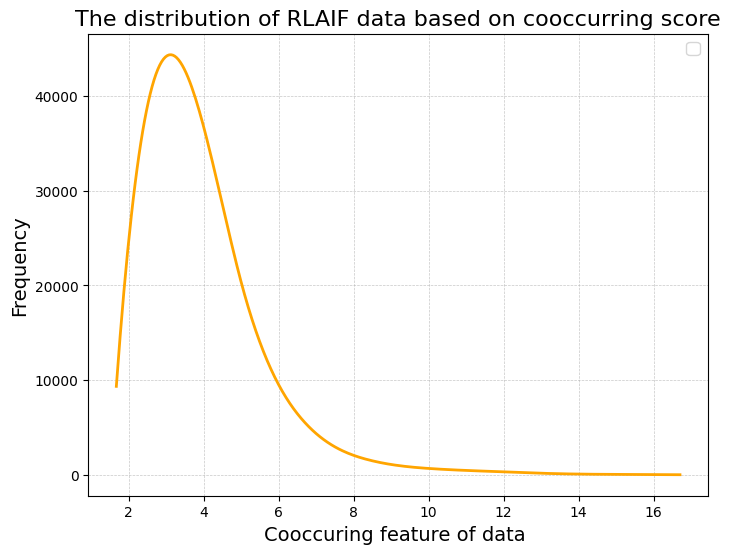

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from collections import Counter

# 假设 data_list 是一个包含数值的列表
# 例如：
# data_list = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]
# values_list = [tensor['Cooccur'].cpu().item() if tensor['Cooccur'].is_cuda else tensor['Cooccur'].item() for tensor in formatted_dataset_sorted]
values_list=[tensor['Cooccur_score'] for tensor in formatted_dataset_sorted]
# 统计频率
num_bins = 10

# 生成直方图
frequencies, bin_edges = np.histogram(values_list, bins=num_bins)

# 计算每个区间的中心点（用于插值）
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 使用样条插值将直方图转换为平滑曲线
bin_centers_smooth = np.linspace(bin_centers[0], bin_centers[-1], 300)  # 插值点
frequencies_smooth = make_interp_spline(bin_centers, frequencies)(bin_centers_smooth)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_smooth, frequencies_smooth, color='orange', lw=2)


# 样式设置
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Cooccuring feature of data ', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('The distribution of RLAIF data based on cooccurring score', fontsize=16)
plt.legend(fontsize=12)
plt.show()
